In [2]:
import sys
sys.path.append("..")

import pandas as pd
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50
import importlib
import consts
importlib.reload(consts)
from preceding_events import *
from combine_data import filter_short_stays_and_different_unit
from bp_for_dose import get_relevant_doses_with_bp
import numpy as np


In [6]:
inputevets_filtered = pd.read_csv("..\\filtered\\input_events_filtered_by_subject_id_and_medicine.csv")
chartevents_filtered = pd.read_csv("..\\filtered\\filtered_chartevents.csv")
icustays_filtered = pd.read_csv("..\\filtered\\filtered_icustays.csv")
patients_filtered = pd.read_csv("..\\filtered\\filtered_patients.csv")
procedureevents_filtered = pd.read_csv("..\\filtered\\filtered_procedureevents.csv")
labevents_filtered = pd.read_csv("..\\filtered\\filtered_labevents.csv")
transfers_filtered = pd.read_csv("..\\filtered\\filtered_transfers.csv")
itemid = pd.read_csv("..\\data\\icu\\d_items.csv")

In [7]:
def generate_equal_size_group(group):
    smaller_size = group["first_careunit"].value_counts().min()
    smaller_gr = group["first_careunit"].value_counts().index[group.first_careunit.value_counts().argmin()]
    bigger_gr = group["first_careunit"].value_counts().index[group.first_careunit.value_counts().argmax()]
    subgroup1 = group[group["first_careunit"] == smaller_gr]
    subgroup2 = group[group["first_careunit"] == bigger_gr].sample(smaller_size)
    return pd.concat([subgroup1, subgroup2], axis=0)

In [8]:
#inputevents_with_bp = get_relevant_doses_with_bp()
inputevents_with_bp = pd.read_csv("temporal_bp_per_dose.csv")
inputevents_with_bp = filter_short_stays_and_different_unit(inputevents_with_bp, icustays_filtered)
inputevents_SICU_MICU = inputevents_with_bp[inputevents_with_bp["first_careunit"].isin(["Medical Intensive Care Unit (MICU)", "Surgical Intensive Care Unit (SICU)"])]

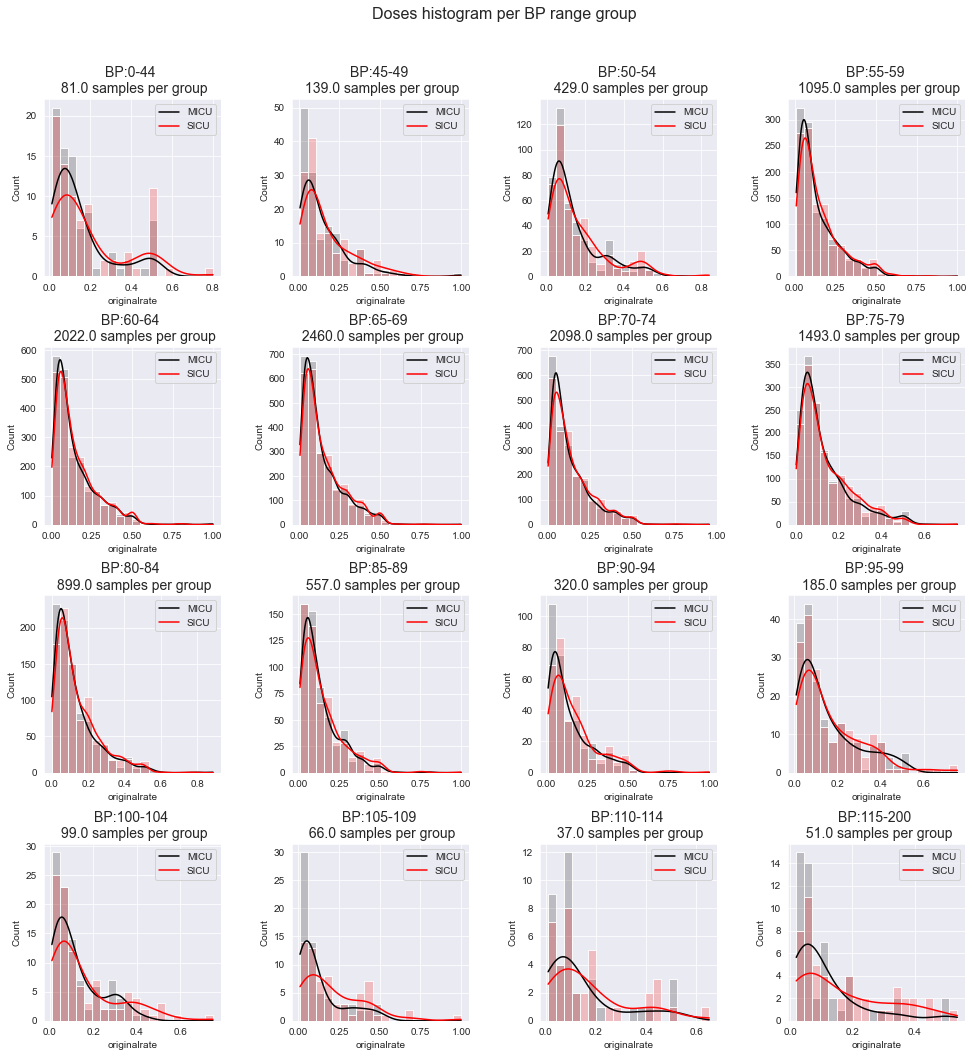

In [40]:
import seaborn as sns
sns.color_palette("Paired")
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 4)
fig.set_size_inches(16, 16)
fig.suptitle('Doses histogram per BP range group', fontsize=16)
for bp_range, i in zip(consts.BP_RANGES, range(0,16)):
    bp_low, bp_high = bp_range 
    bp_section_events = inputevents_SICU_MICU[(inputevents_SICU_MICU["bp_val"] >= bp_low) & 
                                (inputevents_SICU_MICU["bp_val"] <= bp_high) & 
                                (inputevents_SICU_MICU["originalrate"] <= 1) & 
                                (inputevents_SICU_MICU["originalrate"] >= 0)]
    bp_section_events = generate_equal_size_group(bp_section_events)
    number_of_samples = bp_section_events.shape[0]/2
    sns.histplot(data=bp_section_events[["originalrate", "first_careunit"]],
                x="originalrate",
                bins=20, 
                hue="first_careunit", 
                kde=True, 
                ax=axs[i//4, i%4],
                palette={"Surgical Intensive Care Unit (SICU)" : "red", "Medical Intensive Care Unit (MICU)" : "black"},
                alpha=0.2)

    axs[i//4, i%4].set_title(f"BP:{bp_low}-{bp_high} \n {number_of_samples} samples per group", fontsize=14)
    axs[i//4, i%4].legend(labels=["MICU","SICU"])


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()